<a href="https://colab.research.google.com/github/AndresMontesDeOca/RegresionAvanzada/blob/main/TrabajoPractico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Instalacion de Librerias

In [1]:
# Instalacion de Paquetes
!pip install pingouin # No incluido en Google Colab
# !pip install scipy
# !pip install statsmodels

# Version rpy2 que no tiene problemas de compatibilidad
!pip install rpy2==3.5.1

# Cargamos Librerias y Datos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from scipy import stats as st
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tools.tools as smt

# Ignorar Warnings
import warnings
warnings.filterwarnings('ignore')

# Asthetics
sns.set(style='ticks', context='notebook', palette='colorblind', font_scale=1, color_codes=True)

# Recursion limit errors with R Magic
import sys
# sys.setrecursionlimit(50000)

# Activamos R magic
%load_ext rpy2.ipython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7029 sha256=efe314fbf75336cd117625ecdbc5b98e6dd1ed91b303fe953cf92a2ba8b08655
  Stored in directory: /root/.cache/pip/wheels/3d/fe/b0/27a9892da57472e538c7452a721a9cf463cc03cf7379889266
Successfully built littleutils
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp310-cp310-linux_x86_64.whl size=318094 sha256=b6df943633b2143e4a1d048ae5234580baecd96aeb9f1391d7a83d36c5c34c7f
  Stored in directory: /root/.cache/pip/wheels/73/a6/ff/4e75dd1ce1cfa2b9a670cbccf6a1e41c553199e9b25f05

#### Carga de Datos desde Goolge Drive

In [34]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

################################# Datasets ###################################
# Grasa de Cerdos
id = '153lGVzdixcHT-keKg8qmvaoWdPHg6_tB'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('grasacerdos.xlsx')
dataG = pd.read_excel('grasacerdos.xlsx', index_col='Obs') # Cargamos el Dataset
dataG = dataG.replace(to_replace=',', value='.', regex=True) # Reemplazo , por .
dataG = dataG.astype('float') # Transformo en float
%R -i dataG
######################################################
# Peso, Edad, Colesterol
id = '17Dv1WcWlc9ojWa6bnSfD7TCRaVKCKqj0'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('peso_edad_colest.xlsx')
dataP = pd.read_excel('peso_edad_colest.xlsx')
%R -i dataP
######################################################
# Energia
id = '15R-MejMHi1D0y0JUEGxyC3-fsjpYHEUv'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('energia.xlsx')
dataE = pd.read_excel('energia.xlsx')
dataE.rename(columns={'Energía':'Energia'}, inplace=True)
%R -i dataE

In [52]:
%%R

### MVN Henze-Zirkler Test ### -> Lento
# # system(sudo apt install libgsl-dev)
# install.packages('MVN')

# # Wald Test ### -> Rapido
# install.packages('aod')

# # QQ Plot, Bonferroni ### -> Lento
# install.packages('car')

# # LRM Tests ### -> Rapido
# install.packages('lmtest')

# ## Box-Cox Transformation ### -> Rapido
# install.packages('MASS')


####################################
### Installation Status ###
# print(system.file(package='MVN'))

(as ‘lib’ is unspecified)







	‘/tmp/RtmpYZTL2r/downloaded_packages’



# Capitulo I: Regresion Lineal Simple

## Ejercicio 1.1 - Correlacion

In [4]:
# Dataset Grasa de cerdos
data = dataG
display(dataG.head())

,PV,EGD
Obs,,
1,56.81,16.19
2,70.40,22.00
3,71.73,19.52
4,75.10,31.00
5,79.65,23.58


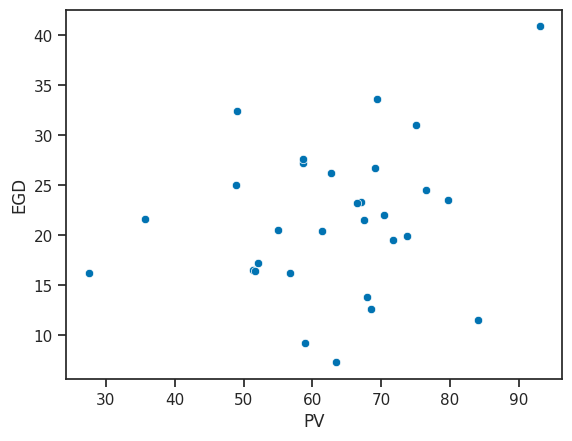

In [5]:
# Punto a -> Scatterplot e interpretacion
sns.scatterplot(data=data, x='PV', y='EGD')
plt.show()

a) No se observa patron de asociacion lineal en el grafico de dispersion

In [6]:
# Calculo del Coeficiente de Correlacion
# display(data.head())
display(pg.corr(data.PV, data.EGD, method='pearson'))
display(pg.corr(data.PV, data.EGD, method='spearman'))
display(pg.corr(data.PV, data.EGD, method='kendall'))

# Verificacion de Normalidad de las Variables
print('\n', pg.normality(data.PV))
print('\n', pg.normality(data.EGD))
print('\n', pg.multivariate_normality(data)) # Henze-Zirkler Test, H0 -> Multiv Normal Dist


,n,r,CI95%,p-val,BF10,power
pearson,30,0.254343,"[-0.12, 0.56]",0.174994,0.546,0.27791


,n,r,CI95%,p-val,power
spearman,30,0.166185,"[-0.21, 0.5]",0.380118,0.142724


,n,r,CI95%,p-val,power
kendall,30,0.112644,"[-0.26, 0.45]",0.395032,0.091095



            W      pval  normal
PV  0.975331  0.692481    True

             W      pval  normal
EGD  0.985135  0.939467    True

 HZResults(hz=0.25394365632841115, pval=0.9049686197809698, normal=True)


- b) Los Coeficientes de Correlacion no son significativos, se observa que los todos los IC de los distintos tests incluyen el 0
- c) No hay suficiente evidencia para rechazar el supuesto de Normalidad Bivariada

## Ejercicio 1.2 - Modelo Lineal Simple

In [7]:
# Dataset de Colesterol, Peso y Edad
data = dataP
data.head()

,peso,edad,colest
0,84,46,354
1,73,20,190
2,65,52,405
3,70,30,263
4,76,57,451


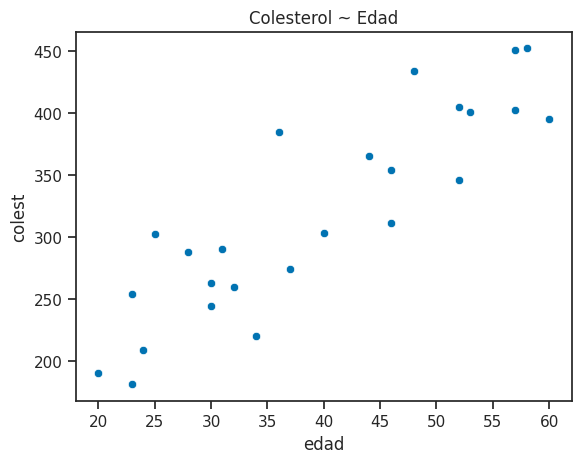

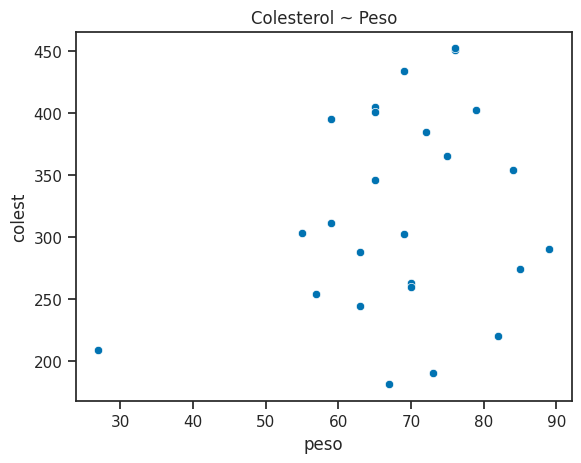

In [8]:
# Diagramas de Dispersion
sns.scatterplot(data=data, x='edad', y='colest')
plt.title('Colesterol ~ Edad')
plt.show()

sns.scatterplot(data=data, x='peso', y='colest')
plt.title('Colesterol ~ Peso')
plt.show()

a) Si, pareciera existir una relacion lineal entre Peso y Colesterol

In [9]:
# Generamos el modelo lineal en R
%%R
data <- dataP

model = lm('colest ~ edad', data=data)
# print(summary(model))
print(model$coef)

(Intercept)        edad 
  95.502004    5.670842 


- b)  El coeficiente de la variable independiente edad es de 5.67 y el de la ordenada al origen 95.5

In [13]:
%%R

# Modelo
print(summary(model))

# Test Wald
library(aod)
wald.test(Sigma = vcov(model), b = coef(model), Terms = 1) # Cuerpo| H0: Coef = 0 (Var no significativa)


Call:
lm(formula = "colest ~ edad", data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-68.311 -22.602  -2.627  27.589  85.348 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  95.5020    26.2545   3.638  0.00138 ** 
edad          5.6708     0.6345   8.937 6.09e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 39.69 on 23 degrees of freedom
Multiple R-squared:  0.7764,	Adjusted R-squared:  0.7667 
F-statistic: 79.87 on 1 and 23 DF,  p-value: 6.094e-09

Wald test:
----------

Chi-squared test:
X2 = 13.2, df = 1, P(> X2) = 0.00028


- c) Tanto el test del modelo, como el test de Wald de la varible independiente indican que ambos son significativos

In [14]:
# Predicciones
data = dataP
print(data.edad.max())

60


In [15]:
# predichos <- predict(object=model, interval='prediction', level=0.95)
# Creo los datos a predecir
to_predict = [25, 48]
newdata = pd.Series(to_predict, name='edad').to_frame()

# Los exporto a R
%R -i newdata

In [16]:
%%R

predict(object=model, newdata=newdata, interval='confidence')

       fit      lwr      upr
0 237.2730 212.1954 262.3507
1 367.7024 347.8058 387.5990


- d) 237.27 y 367.7 de Colesterol para 25 y 48 anos respectivamente. Para 80 anos no deberia estimarse, ya que esta fuera del dominio del modelo

In [24]:
%%R

# Normalidad de Residuos Analitica
print(shapiro.test(model$resid))

# Normalidad de residuos grafica
# library(car)
# qqPlot(model$resid)


	Shapiro-Wilk normality test

data:  model$resid
W = 0.96478, p-value = 0.5175



- e1) No hay suficiente evidencia para rechazar el supuesto de Normalidad de los residuos

In [21]:
# # Residuals Variance (Homosedasticity)
# Analisis Analitico (Breusch-Pagan Test) -> R | H0: Residuos Homocedasticos
%%R

# library(lmtest)
# print(bptest(model))

resid = model$resid
fitted = model$fitted.values

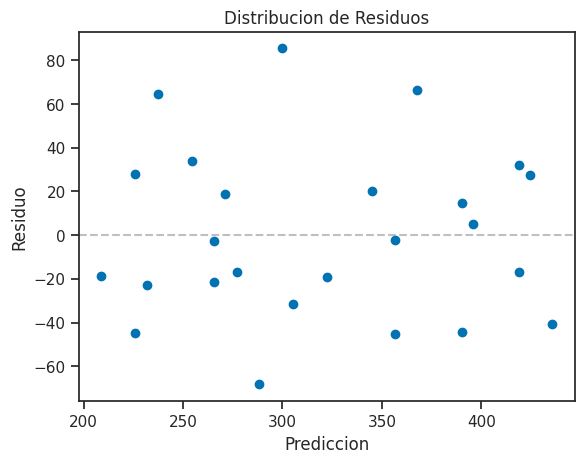

In [22]:
# # Analsis Grafico -> Python

# Importo Datos desde R
%R -o resid
%R -o fitted

plt.scatter(x=fitted, y=resid)
plt.xlabel( 'Prediccion')
plt.ylabel('Residuo')
plt.title('Distribucion de Residuos')
plt.axhline(color='grey', linestyle='dashed', alpha=0.5)
plt.show()
# No se observa estructura de embudo

- e2) Tampoco hay suficiente evidencia para rechazar su homocedasticidad. En el analisis grafico no se observa la forma de "embudo"

## Ejercicio 1.3 - Transformacion de Variables

,Hora,Energia
0,1,598
1,2,527
2,3,530
3,4,528
4,5,452


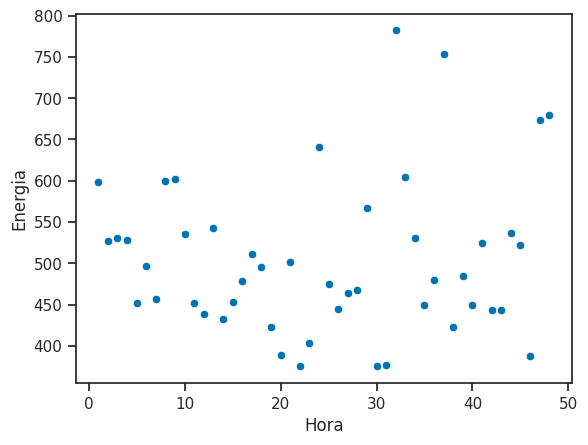

,n,r,CI95%,p-val,BF10,power
pearson,48,0.078342,"[-0.21, 0.35]",0.596612,0.206,0.082576


In [41]:
# Cargamos los datos
data = dataE

display(data.head())

# Ploteamos
sns.scatterplot(data=data, x='Hora', y='Energia')
plt.show()

# Correlacion
pg.corr(data.Hora, data.Energia, method='pearson')

- a) Realizando un Test de Pearon, no podemos rechazar la HO de que las variables no estan correlacionadas

In [60]:
# Linear Regression Models
# En R

%%R
data <- dataE

model <- lm('Energia ~ Hora', data=data)
resid = model$resid
fitted = model$fitted.values
# print(summary(model_colest_R))
# print(anova(model_colest_R))

# Analisis Grafico
# qqPlot(resid)
print(shapiro.test(resid))


	Shapiro-Wilk normality test

data:  resid
W = 0.92988, p-value = 0.006752



- Hay suficiente evidencia para rechazar la HO de Normalidad de los residuos


In [65]:
%%R


# # Analisis Analitico (Breusch-Pagan Test) -> R | H0: Residuos Homocedasticos
library(lmtest)
print(bptest(model))


	studentized Breusch-Pagan test

data:  model
BP = 3.3397, df = 1, p-value = 0.06763



- Border en la Homocedesitcidad, pero no se rechaza

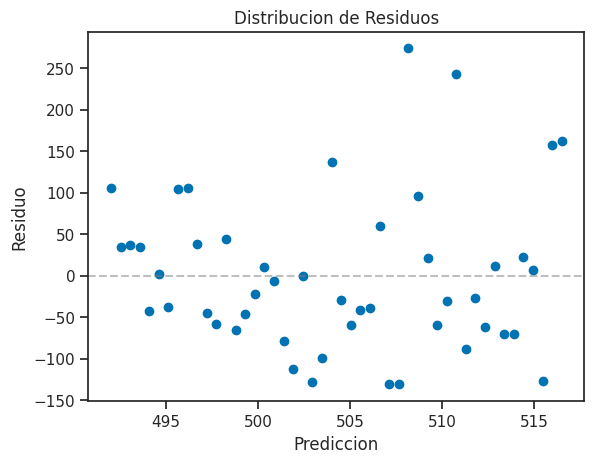

In [66]:


# # Analsis Grafico -> Python

# Importo Datos desde R
%R -o resid
%R -o fitted

plt.scatter(x=fitted, y=resid)
plt.xlabel( 'Prediccion')
plt.ylabel('Residuo')
plt.title('Distribucion de Residuos')
plt.axhline(color='grey', linestyle='dashed', alpha=0.5)
plt.show()
# No se observa estructura de embudo

- Confirmamos la Homosedasticidad de manera grafica, no observandose patrones del tipo embudo



In [56]:
# Analisis Analitico (Durbin-Watson Test) -> R | H0 No Auto-Correlacion
# 2=No Correlacion (Independecia)| 0=Correlacion Pos | 4=Correlacion Neg
%%R

library(lmtest)
dwtest(model, alternative='two.sided', iterations=1000)


	Durbin-Watson test

data:  model
DW = 1.872, p-value = 0.5482
alternative hypothesis: true autocorrelation is not 0



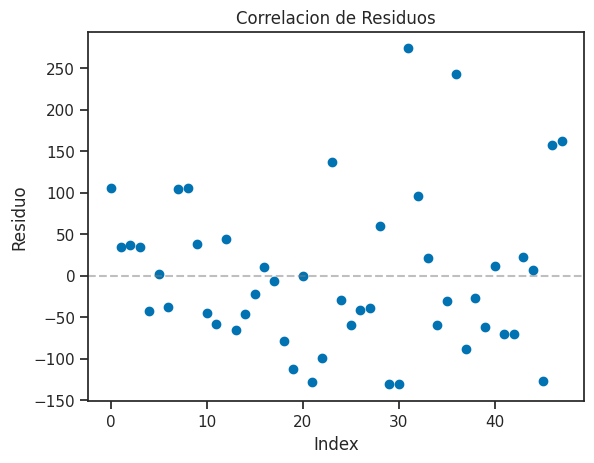

Durbin-Watson: 1.871987982293651


In [59]:
# Analsis Grafico -> Python
data=dataE

plt.scatter(x=data.index, y=resid)
plt.xlabel( 'Index')
plt.ylabel('Residuo')
plt.title('Correlacion de Residuos')
plt.axhline(color='grey', linestyle='dashed', alpha=0.5)
plt.show()
# No se observa estructura

# Analisis Analitico -> Python
print('Durbin-Watson:', sm.stats.durbin_watson(resid)) # Sin validacion Estadistica

- Hay suficiente evidencia para rechazar la HO de Normalidad de los residuos
- Border en la Homocedesitcidad, pero no se rechaza
- Tampoco se puede rechazar la HO de No-Autocorellacion, y decimos que los residuos estan no auto-correlacionados


	Shapiro-Wilk normality test

data:  model$resid
W = 0.92988, p-value = 0.006752



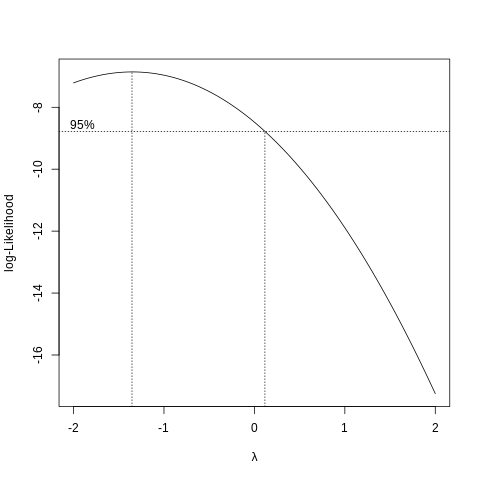

In [67]:
# Box Cox Transformation -> R
%%R
data = dataE
library(MASS)

# Generamos el modelo y verificamos la Normalidad de los residuos
model <- lm('Energia ~ Hora', data=data)
print(shapiro.test(model$resid))

# Buscamos el Lambda  optimo -> Si Lambda  = 0 -> log10(y) | y**Lambda
boxcox(object = model, plotit=TRUE)

- El Lambda de -1.5

In [72]:
# # Transformamos/Agregamos Variables en Dataset original -> Python
data = dataE

lmb = -1.5
Energia_trans = pd.Series(data['Energia']**lmb, name='Energia_trans')
# dist_log10 = pd.Series(np.log10(data['dist']), name='dist_log10')

dataE2 = pd.concat([data, Energia_trans], axis=1)
display(dataE2.head())

%R -i dataE2 # Importamos a R

,Hora,Energia,Energia_trans
0,1,598,0.000068
1,2,527,0.000083
2,3,530,0.000082
3,4,528,0.000082
4,5,452,0.000104


In [77]:
# # Generamos el nuevo modelo con las nuevas variables transformadas, y veridicamos su Normalidad
%%R

model_2 <- lm('Energia_trans ~ Hora', data=dataE2)
print(shapiro.test(model_2$resid))



	Shapiro-Wilk normality test

data:  model_2$resid
W = 0.9797, p-value = 0.5661



- Residuos normales

In [79]:
# Analisis Analitico (Breusch-Pagan Test) -> R | H0: Residuos Homocedasticos
%%R

library(lmtest)
bptest(model_2)


	studentized Breusch-Pagan test

data:  model_2
BP = 3.364, df = 1, p-value = 0.06664



- Siguen siendo border, pero Homocedasticos al fin

In [80]:
# Analisis Analitico (Durbin-Watson Test) -> R | H0 No Auto-Correlacion
# 2=No Correlacion (Independecia)| 0=Correlacion Pos | 4=Correlacion Neg
%%R

library(lmtest)
dwtest(model_2, alternative='two.sided', iterations=1000)


	Durbin-Watson test

data:  model_2
DW = 1.8827, p-value = 0.5734
alternative hypothesis: true autocorrelation is not 0



- Tambien son no auto-correlacionados

In [106]:
# Datos a Predecir (Python)
to_predict = [27.5]
newdata = pd.Series(to_predict, name='Hora').to_frame()
%R -i newdata

In [110]:

%%R
# Bandas de Prediccion
predichos <- predict(object=model_2, interval='confidence', level=0.95, newdata=newdata)
nuevos_datos <- data.frame(predichos, data)

In [111]:
nuevos_datos.head()

,fit,lwr,upr,Hora,Energia
1,0.000093,0.000046,0.00014,1,598
2,0.000093,0.000046,0.00014,2,527
3,0.000093,0.000046,0.00014,3,530
4,0.000093,0.000046,0.00014,4,528
5,0.000093,0.000046,0.00014,5,452


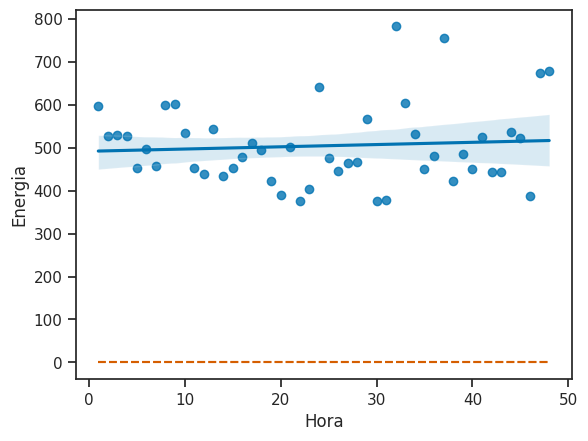

In [112]:
# Graficamos en Python
%R -o nuevos_datos

# Grafico
sns.regplot(data=nuevos_datos, x='Hora', y='Energia')
sns.lineplot(data=nuevos_datos, x='Hora', y='lwr', linestyle='--', color='r')
sns.lineplot(data=nuevos_datos, x='Hora', y='upr', linestyle='--', color='r')
plt.show()